<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [1]:
import math
import random
import os
import sys
import datetime

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import ray

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from tqdm import trange
 
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
from common.multiprocessing_env import SubprocVecEnv
from common.utils import *
from common.evaluate import *

from agent.network import ActorCritic
from agent.ppo import ppo_iter, ppo_update

use_cuda = torch.cuda.is_available()
device   = torch.device("cpu") # "cuda" if use_cuda else "cpu")
print("device: {}".format(device))

# Line notify

url = "https://notify-api.line.me/api/notify"
token = '88RzP9jGYYEusPQKqpdWpELln97VxOah7ZIab2MyV1R'
headers = {"Authorization" : "Bearer "+ token}

benchmark_name = 'figureeight0'
print('benchmark: {}'.format(benchmark_name))

device: cpu
benchmark: figureeight0


In [9]:
ray.init(num_cpus=3, include_webui=False, ignore_reinit_error=True)

Calling ray.init() again after it has already been called.


In [10]:
from flow.utils.registry import make_create_env
benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.flow_params
HORIZON = flow_params['env'].horizon

def make_env(create_env):
    def _thunk():
        env = create_env()
        return env
    return _thunk

In [11]:
# Create Environment
num_envs = 3
create_env, env_name = make_create_env(params=flow_params, version=0)

envs = [make_env(create_env) for i in range(num_envs)]
envs = SubprocVecEnv(envs)

evs = [PolicyEvaluator.remote(create_env) for i in range(num_envs)]

 Starting SUMO on port 36270
 Starting SUMO on port 47083
 Starting SUMO on port 59954


# Train

In [12]:
num_inputs  = envs.observation_space.shape[0]
num_outputs = envs.action_space.shape[0]

#Hyper params:
lr = 5e-4
training_iter = 500
num_rollouts = 5
num_steps = HORIZON * num_rollouts
mini_batch_size = 128
num_sgd_iter = 10
fcnet_hiddens = [100, 50, 25]
gae_lambda = 0.97

model = ActorCritic(num_inputs, num_outputs, fcnet_hiddens, std=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

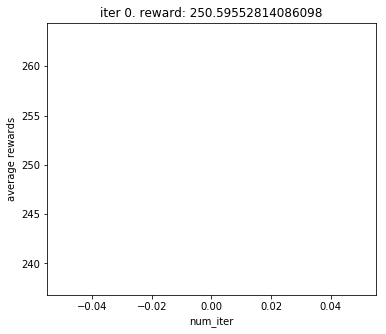

  1%|          | 3/500 [03:42<10:13:55, 74.12s/it]

In [ ]:
now = datetime.datetime.now()
now = str(now).replace(':', '-').replace(' ', '-')
now = now[:now.find('.')]
result_path = './result/ppo/' + now
os.makedirs(result_path)
image_path = result_path + '/reward_history.png'

test_rewards, num_iters = [], []

state = envs.reset()

for num_iter in trange(training_iter):
    state = envs.reset()
    trajectory = {'log_probs':[], 'values':[], 'states':[], 
                  'actions':[], 'rewards':[], 'masks':[]}

    for _ in range(num_steps):
        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)
        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        log_prob = dist.log_prob(action)
        append_trajectory(trajectory, log_prob, value, state, action, reward, done, device)
        state = next_state

    if num_iter % 25 == 0:
        model_id = ray.put(model)
        results_ids = [ev.test_env.remote(device, model_id) for ev in evs]
        test_reward = np.mean(ray.get(results_ids))
        test_rewards.append(test_reward)
        num_iters.append(num_iter)
        plot_and_save(num_iters, test_rewards, image_path)
        model_path = result_path + '/checkpoint' + str(num_iter) + '.pt'
        torch.save(model.state_dict(), model_path)
        send_line(url, headers, 'epoch: {}'.format(num_iter), image_path)
       
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, trajectory, tau=gae_lambda)
    cat_trajectory(trajectory, returns)
    
    ppo_update(model, optimizer, num_sgd_iter, mini_batch_size, trajectory)

# Test

In [ ]:
model = ActorCritic(num_inputs, num_outputs, fcnet_hiddens).to(device)

model_path = './result/ppo/2019-04-02-02-06-26/checkpoint475.pt'
model.load_state_dict(torch.load(model_path))
model.eval()
model_id = ray.put(model)

In [ ]:
env = make_vis_env(benchmark_name)

test_env(env, device, model)